## Final project. Applied Mathematics / Numerical Analysis / P1.4

Using Lagrangian finite elements with Chebyshev nodes, defined on square, of arbitrary order

Find the solution of 

$$
-\Delta \mathbf u + \mathbf u = \mathbf f \text{ in } \Omega, \qquad n \cdot \delta u = 0 \text{ on } \partial \Omega
$$

on the square $\Omega = [0,1]^2$. For the sake of simplicity you can consider just **one finite element** and homogeneous Neumann boundary conditions. 

The above problem can be rewritten in matrix form as

$$
A u = (K+M) u =  b
$$

where $K$ is the stiffness matrix, and $M$ is the mass matrix.

In order to do so, express $u$ as a linear combination of basis functions, multiply from the left with a basis function, and integrate by parts the laplacian to obtain:

$$
K_{ij} := \int_\Omega \nabla v_i \cdot \nabla v_j,\qquad M_{ij} = \int_\Omega v_i v_j, \qquad b_i = \int_\Omega v_i f
$$

In [114]:
%pylab inline
%matplotlib inline
import sympy as sym
import numpy.polynomial.legendre as leg
from mpl_toolkits.mplot3d import Axes3D

Populating the interactive namespace from numpy and matplotlib


### 1 Construct (or use the available functions from numpy/scipy) the chebishev nodes of given order

Once you constructed them, plot them.

In [115]:
# Chebyshev nodes for the interval [0,1]
def cheby_nodes(n):
    cheby = zeros((n))
    const = pi*0.5/n
    for i in range(n):
        cheby[n-i-1] = 0.5 + 0.5*cos((2*i+1)*const)
    return cheby

order = 9
C = cheby_nodes(order)

### 2 Construct (or use the available functions from numpy/scipy) the one-dimensional Lagrange basis functions on the Chebishev nodes
Make sure each entry of basis_1d is a callable function, that you can evaluate at a given point. Plot all of the basis functions, using a numpy array `Vs`, storing all basis functions evaluated on evenly spaced points, called `s`

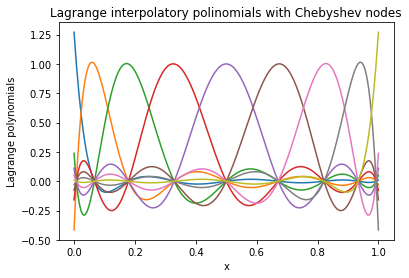

In [116]:
def lagrange_1d(q, der):
    # q: array of interpolatory points
    # der: order of derivative
    t = sym.symbols('t')
    Ln = [1 for i in range(len(q))]
    for i in range(len(q)):
        for j in range(len(q)):
            if j !=i :
                Ln[i] *= (t-q[j])/(q[i]-q[j])
        Ln[i] = Ln[i].diff(t,der)
        Ln[i] = sym.lambdify(t, Ln[i], 'numpy')
    return Ln

def evaluate_functions(order, n_points, x, basis):
    # order: number of basis functions
    # plot_resolution: number of points where to evaluate the polynomials
    # x: array with elements where to evaluate the polynomials
    # basis: basis functions
    Vs = zeros((n_points, order))
    for i in range(order):
        Vs[:,i] = basis[i](x)
    return Vs

def plot_functions(func, x, the_title, the_ylabel):
    # func: function(s) to plot (a matrix is accepted, where the 
    # the number of columns is the number of functions to plot, and the rows 
    # are different domain points)
    # x: domain points
    # the_title: title of the plot
    # the_ylabel: ylabel of the plot (x is set by default)
    _ = plot(x, func)
    _ = title(the_title)
    _ = xlabel("x")
    _ = ylabel(the_ylabel)

plot_resolution = 257
s = np.linspace(0,1,plot_resolution)

basis_1d = lagrange_1d(C,0)
    
Vs = evaluate_functions(order, plot_resolution, s, basis_1d)
plot_functions(Vs, s, "Lagrange interpolatory polinomials with Chebyshev nodes", "Lagrange polynomials")

### 3 Construct three one-dimensional quadrature formulas, to integrate the matrices, the right hand side, and the error

In general the size of the quadratures should be selectable by the user.

Anything that should be evaluated on one of quadrature points, should be named accordingly (i.e., using a suffix `m,r,e`) for the three collections

In [117]:
quadrature_size_matrices = 9
quadrature_size_rhs      = 9
quadrature_size_error    = 9

# Quadrature points: roots of the Legendre polynomials
def gaussLeg_quadrature(quad_n):
    # quad_n: number of quadrature points
    points, weights = leg.leggauss(quad_n)
    
    # Shift the points and weights to the interval [0,1]
    points = 0.5 * (points + 1)
    weights = weights * 0.5
    
    return points, weights

# Quadrature points and weights for the matrices
Qm, Wm = gaussLeg_quadrature(quadrature_size_matrices)
# Quadrature points and weights for the rhs
Qr, Wr = gaussLeg_quadrature(quadrature_size_rhs)
# Quadrature points and weights for the error
Qe, We = gaussLeg_quadrature(quadrature_size_error)

### 4 Evaluate all the one dimensional basis functions at each collection of quadrature points

Store the results in three different numpy arrays, one for quadrature. Use suffix `m,r,e` for the arrays representing the basis functions evaluated at the quadrature points to be used for the matrices, rhs, and errors respectively.

In [118]:
# One dimensional basis functions at the matrices quadrature points
Vm = evaluate_functions(order, quadrature_size_matrices, Qm, basis_1d)
# One dimensional basis functions at the rhs quadrature points
Vr = evaluate_functions(order, quadrature_size_rhs, Qr, basis_1d)
# One dimensional basis functions at the error quadrature points
Ve = evaluate_functions(order, quadrature_size_error, Qe, basis_1d)

### 5 Evaluate the derivatives of the basis functions at each collection of quadrature points

Store the results in three different numpy arrays, one for quadrature. Use suffix `m,r,e` for the arrays representing the basis functions evaluated at the quadrature points to be used for the matrices, rhs, and errors respectively.

In [119]:
derivatives = lagrange_1d(C, 1)

# One dimensional derivative of the basis functions at the matrices quadrature points
Dm = evaluate_functions(order, quadrature_size_matrices, Qm, derivatives)
# One dimensional derivative of the basis functions at the rhs quadrature points
Dr = evaluate_functions(order, quadrature_size_rhs, Qr, derivatives)
# One dimensional derivative of the basis functions at the error quadrature points
De = evaluate_functions(order, quadrature_size_error, Qe, derivatives)

### 6 Construct the two dimensional quadrature formulas as tensor products of the one dimensional ones

Given two one dimensional quadrature formulas with points $x_r$ and $y_q$, we can construct the corresponding two dimensional quadrature formulas by using `einsum` to obtain the weights of higher dimensional tensor product quadrature formulas, on the points $(x_r, y_q)$:

$$
X_{qr} = (x_r, y_q),  J2_{qr} = w_r w_q
$$

Use lexycographical ordering w.r.t. to C: `x` runs faster than `y`.

Integration of a scalar function of two variables on the square can then be approximated as

$$
\int_0^1 \int_0^1 f(x,y) dx \, dy \sim \sum_{r=0}^{n_q-1}\sum_{q=0}^{n_q-1} f(x_r, y_q)  w_r w_q = \sum_{r=0}^{n_q-1}\sum_{q=0}^{n_q-1} f(X_{qr})  J_{qr}
$$


In [120]:
# Two dimensional weights for the matrices
W2m = einsum('q,r -> qr',Wm, Wm)
# Two dimensional weights for the rhs
W2r = einsum('q,r -> qr',Wr, Wr)
# Two dimensional weights for the error
W2e = einsum('q,r -> qr',We, We)

### 7 Construct the two dimensional basis functions as tensor products of the one dimensional ones

Given a set of one dimensional basis functions, one can construct the tensor product space for two dimensional problems by defining

$$
V_{ij}(x,y) := v_i(y) v_j(x), \quad i,j = 0,\ldots,n-1.
$$

If we only need these to be evaluated at some quadrature points, $V_{iq} = v_i(x_q)$, we can construct the corresponding two dimensional basis functions by using `einsum` to obtain higher dimensional arrays on tensor product points:

$$
V2_{qr\, ij} =  v_i(y_q) v_j(x_r)
$$

representing one two dimensional basis function (identified by the two indices $i,j$, one indicating the $j$-th basis function along $x$, and the other identifying the $i$-th basis function along $y$), evaluated at the point $(x_r, y_q)$.

Notice that we use lexycographical ordering: `x` runs faster than `y`, both for the numbering of the basis functions and for the order of the quadrature points. Moreover, we group together the indices running over the quadrature points, and the ones running over the basis function indices, while maintaining the lexycographical ordering.

This allows you to resize the arrays, so that the results only have two dimensional matrices, with shape `(quadrature_size_xxx^2,order^2)`. 

In [121]:
# Two dimensional basis functions
V2s = einsum('qi, rj -> qrij', Vs, Vs)

# Two dimensional basis functions evaluated at the quadrature points
V2m = einsum('qi, rj -> qrij', Vm, Vm)
V2r = einsum('qi, rj -> qrij', Vr, Vr)
V2e = einsum('qi, rj -> qrij', Ve, Ve)

# Two dimensional: basis functions * derivative of basis functions evaluated at the wuadrature points
VDm = einsum('qi, rj -> qrij', Vm, Dm)
DVm = einsum('qi, rj -> qrij', Dm, Vm)

Notice that, since you used the correct ordering, you can actually plot some of the basis functions, for example the 2 along x, 3 along y, as:

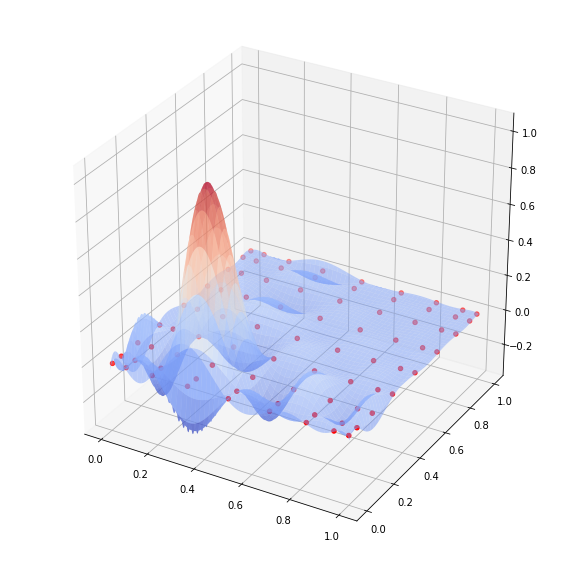

In [122]:
X = meshgrid(s, s)
Q = meshgrid(C, C)

fig = figure(figsize=[10,10])
ax = fig.gca(projection='3d')
surf2 = ax.plot_surface(X[0], X[1], V2s[:,:,2,3], rstride=5, cstride=5, cmap=cm.coolwarm, alpha=0.5)
scatter = ax.scatter(Q[0], Q[1], zeros_like(Q[0]), c='r', marker='o')

### 8 Assemble the matrices and the right hand side

Using `einsum`, assemble the arrays representing the matrices and then resize them to be two-dimensional. Careful on how the stiffness matrix is defined:

$$
K_{ij \, kl} = \int_{\Omega} \nabla v_{ij} \cdot \nabla v_{kl} = \sum_q \sum_r (v'_j(x_r)v_i(y_q) v'_l(x_r)v_k(y_q) +v_j(x_r)v'_i(y_q) v_l(x_r)v'_k(y_q) )w_r w_q
$$

Using summation convention, this is equivalent to:

```
(Vm[i][q]*Dm[j][r] Vm[k][q]*Dm[l][r] + Dm[i][q]*Vm[j][r] *Dm[k][q]Vm[l][r])W[r]*W[q]
```
or
```
(VDm[q][r][i][j]^2 + DVm[q][r][i][j]^2)W2[q,r]
```

In [123]:
# M = einsum('qrij, qrkl, q, r', V2m, V2m, Wm, Wm)
M = einsum('qrij, qrkl, qr', V2m, V2m, W2m) # The same as before
M = M.reshape((order**2, order**2))

# We need two part for the K matrix (as there's a sum)
K1 = einsum('qrij, qrkl, qr', VDm, VDm, W2m)
K2 = einsum('qrij, qrkl, qr', DVm, DVm, W2m)
K = K1 + K2
K = K.reshape((order**2, order**2))

A = K + M

### 9 Using a known solution, construct a right hand side that would produce the given solution, and assemble it

Given a solution that satisfies the boundary conditions (for example:) 

$$
u(x,y) = \cos(\pi x)\cos(3\pi y)
$$
compute its laplacian, put a minus in front of it, and sum $u$ to it. The result is the forcing term $f$ that you have to use in order to obtain $u$ as a solution to the problem. Call it `my_function`, compute the right hand side by integrating with the basis functions and reshape it to be a vector of size `order^2`:

In [124]:
# Get the function F (the one of the rhs)
def my_function(x,y):
    F = zeros((len(y), len(x)))
    for i in range(len(y)):
        for j in range(len(x)):
            F[i,j] = (1.0 + 10.0*pi**2) * cos(pi*x[j])*cos(3*pi*y[i])
    return F

def exact_sol(x,y):
    sol = zeros((len(y), len(x)))
    for i in range(len(y)):
        for j in range(len(x)):
            sol[i,j] = cos(pi*x[j])*cos(3*pi*y[i])
    return sol

Fr = my_function(Qr,Qr)
b = einsum('qrij, qr, qr', V2r, Fr, W2r)
b = b.reshape((order**2))

### 10 Solve the linear system, and plot the solution

Use a direct solver to solve the linear system. Once you have the coefficients `u` as a vector, reshape it to a matrix, and use einsum to have its values on the `s` space.

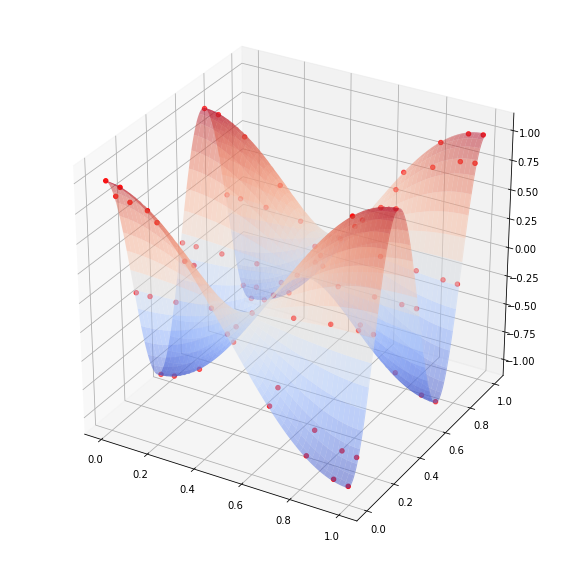

In [125]:
u = solve(A,b)
u = reshape(u, (order, order))
es = exact_sol(s,s)

us = einsum('qrij, ij', V2s, u)

X = meshgrid(s, s)
Q = meshgrid(C, C)

fig = figure(figsize=[10,10])
ax = fig.gca(projection='3d')
surf2 = ax.plot_surface(X[0], X[1], us, rstride=5, cstride=5, cmap=cm.coolwarm, alpha=0.5)
#surf3 = ax.plot_surface(X[0], X[1], es, rstride=5, cstride=5, cmap=cm.coolwarm, alpha=0.5)
scatter = ax.scatter(Q[0], Q[1], u, c='r', marker='o')

### 11 Compute the L2 error of the solution

The L2 error is defined as 

$$
\| u - u_h \| := \sqrt{\int_\Omega (u(x,y) - u^{ij} V_{ij}(x,y))^2 dx\, dy } \sim \sqrt{\sum_q \sum_r (u(x_r, y_q) -V_{qrij} u^{ij})^2 W_{qr}}
$$

use the quadrature formula and the matrix you constructed above to compute the approximate solutions at the quadrature points.

In [126]:
# For this part, use the error quadratures
tmp = (exact_sol(Qe, Qe) - einsum('qrij, ij', V2e, u))**2
calc = einsum('qr,qr', tmp, W2e)

L2_error = sqrt(calc)
print(L2_error)

0.0031298061733133005


### 12 Group together all of the above in a function

The function should take as input the `degree` of the one dimensional basis space, the degrees of the three quadrature formulas, a number of points where you want to produce the outputs.

Once you have the function, create a `log-log` plot of the L2 error with respect to the input degree

In [131]:
order = 9
plot_resolution = 257
quadrature_size_matrices = 9
quadrature_size_rhs      = 9
quadrature_size_error    = 9

def run(order, n_quad_mat, n_quad_rhs, n_quad_err, plot_resolution):
    
    # Interpolation points + basis functions
    Cheby_nodes = cheby_nodes(order)
    s = np.linspace(0,1,plot_resolution)
    basis_1d = lagrange_1d(Cheby_nodes,0)
    Vs = evaluate_functions(order, plot_resolution, s, basis_1d)
    #plot_functions(Vs, s, "Lagrange interpolatory polinomials with Chebyshev nodes", "Lagrange polynomials")
    
    # Quadratures
    Qm, Wm = gaussLeg_quadrature(quadrature_size_matrices)
    Qr, Wr = gaussLeg_quadrature(quadrature_size_rhs)
    Qe, We = gaussLeg_quadrature(quadrature_size_error)
    
    # Evaluate basis functions in quadrature points
    Vm = evaluate_functions(order, quadrature_size_matrices, Qm, basis_1d)
    Vr = evaluate_functions(order, quadrature_size_rhs, Qr, basis_1d)
    Ve = evaluate_functions(order, quadrature_size_error, Qe, basis_1d)
    
    # Evaluate derivatives of basis functions in quadrature points
    derivatives = lagrange_1d(Cheby_nodes, 1)
    Dm = evaluate_functions(order, quadrature_size_matrices, Qm, derivatives)
    Dr = evaluate_functions(order, quadrature_size_rhs, Qr, derivatives)
    De = evaluate_functions(order, quadrature_size_error, Qe, derivatives)
    
    # Two dimension weights
    W2m = einsum('q,r -> qr',Wm, Wm)
    W2r = einsum('q,r -> qr',Wr, Wr)
    W2e = einsum('q,r -> qr',We, We)
    
    # Two dimensional basis functions and derivatives at the quadrature points
    V2s = einsum('qi, rj -> qrij', Vs, Vs)
    V2m = einsum('qi, rj -> qrij', Vm, Vm)
    V2r = einsum('qi, rj -> qrij', Vr, Vr)
    V2e = einsum('qi, rj -> qrij', Ve, Ve)
    VDm = einsum('qi, rj -> qrij', Vm, Dm)
    DVm = einsum('qi, rj -> qrij', Dm, Vm)
    
    # Assemble of matrices
    M = einsum('qrij, qrkl, qr', V2m, V2m, W2m) # The same as before
    M = M.reshape((order**2, order**2))
    K1 = einsum('qrij, qrkl, qr', VDm, VDm, W2m)
    K2 = einsum('qrij, qrkl, qr', DVm, DVm, W2m)
    K = K1 + K2
    K = K.reshape((order**2, order**2))
    A = K + M
    
    Fr = my_function(Qr,Qr)
    b = einsum('qrij, qr, qr', V2r, Fr, W2r)
    b = b.reshape((order**2))
    
    # Solve the system
    u = solve(A,b)
    u = reshape(u, (order, order))
    us = einsum('qrij, ij', V2s, u)
    
    # Compute L2 error
    tmp = (exact_sol(Qe, Qe) - einsum('qrij, ij', V2e, u))**2
    calc = einsum('qr,qr', tmp, W2e)
    L2_error = sqrt(calc)
    print(L2_error)
    
    # Plot solution
    #X = meshgrid(s, s)
    #Q = meshgrid(C, C)
    #fig = figure(figsize=[10,10])
    #ax = fig.gca(projection='3d')
    #surf2 = ax.plot_surface(X[0], X[1], us, rstride=5, cstride=5, cmap=cm.coolwarm, alpha=0.5)
    #scatter = ax.scatter(Q[0], Q[1], u, c='r', marker='o')
    return L2_error
    
run(order, quadrature_size_matrices, quadrature_size_rhs, quadrature_size_error, plot_resolution)

0.0031298061733133005


0.0031298061733133005

0.9614679774947954
0.758175970511033
0.3651872118961605
0.19146119160125677
0.06362926035178469
0.03414193138414183
0.006020135697827163
0.0031298061733133005
0.0003421545762697545
0.00017587205038331572
1.316211508277331e-05
6.731292571895063e-06
3.677577463604745e-07


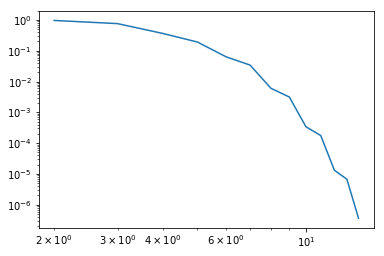

In [132]:
# Log-log plot of the error vs order-quadrature
error = []
for i in range(2,15):
    order = i
    quadrature_size_matrices = i
    quadrature_size_rhs = i
    quadrature_size_error = i
    error.append(run(order, quadrature_size_matrices, quadrature_size_rhs, quadrature_size_error, plot_resolution))
    x_error = np.linspace(2,i,i-1)
loglog(x_error, error)

0.758175970511025
0.758175970511033
0.950924483564925
0.9509244835649263
25.044488615302523
25.04448861530154
25.044488615420892


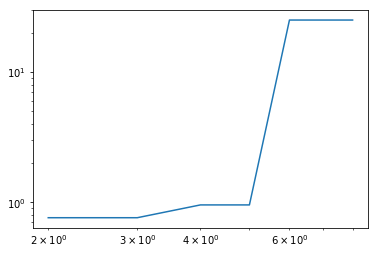

In [133]:
# Plot of the error when we use a number of quadrature points lower that the order of the polynomials
# For n_quadrature=3 we are able to integrate exactly polynomials of order 2*3-1=5 (and we can see that in 
# graph: for polynomials of order >= 6 the error grows consirably)
error = []
for i in range(2,9):
    order = i
    quadrature_size_matrices = 3
    quadrature_size_rhs = 3
    quadrature_size_error = 3
    error.append(run(order, quadrature_size_matrices, quadrature_size_rhs, quadrature_size_error, plot_resolution))
    x_error = np.linspace(2,i,i-1)
loglog(x_error, error)

### 13 [OPTIONAL] Augment the function above

Make it take an optional argument that switches from a direct to an iterative solver (use CG, with a simple preconditioner of your choice).

Make a plot of cost it takes to run with iterative VS direct solvers. Is there a cross over point? For what degree?

### 14 [OPTIONAL] Matrix free

Using the iterative solver, implement a matrix-free approach where the computation of the matrices is substituted with a  function that returns the *matrix-vector* product. In doing so, you must take care of rewriting the assemble of the matrix as a sum of many *matrix-matrix* products exploiting all the possible tensor products. 

Compare and comment the compuational cost of 100 matrix-vector product when the matrix is assembled and when it is computed on-the-fly as a function of the degree of the finite element. Is there a cross-over point? Is matrix free always convenient?

To see an explanation of how matrix free works, take a look at this page: 

https://www.dealii.org/8.5.0/doxygen/deal.II/step_37.html